In [1]:
## MODEL TO MEASURE Volatility

In [2]:
## notebook imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2

from math import sqrt
sns.set()

In [5]:
raw_csv = pd.read_csv('Index2018.csv')
df_copy = raw_csv.copy()
df_copy['date'] = pd.to_datetime(df_copy['date'],dayfirst=True)
df_copy.set_index('date',inplace=True)
df_copy = df_copy.asfreq('b')
df_copy = df_copy.fillna(method='ffill')

In [6]:
### Analyzing FTSE column as market_value(price)

df_copy['market_value'] = df_copy['ftse']

In [7]:
df_copy.drop(['spx','dax','ftse','nikkei'],inplace=True,axis=1)

In [8]:
df_copy.head()

,market_value
date,
1994-01-07,3445.98
1994-01-10,3440.58
1994-01-11,3413.77
1994-01-12,3372.02
1994-01-13,3360.01


In [9]:
size = int(len(df_copy)*0.8)
df = df_copy.iloc[:size]
df_test = df_copy.iloc[size:]

### LLR test

In [12]:
def llr_test(model_1,model_2,df=1):
    ''' can only use this when order of simple model is nested inside the complex model'''
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,df).round(3)
    return p
    

### Creating Returns

In [13]:
df['returns']=df['market_value'].pct_change(1).mul(100)

<ipython-input-13-51bce0380152>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns']=df['market_value'].pct_change(1).mul(100)


### Creating Squared Returns

In [14]:
df['sq_returns'] = df['returns'].mul(df['returns'])

<ipython-input-14-01cb9034dfde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sq_returns'] = df['returns'].mul(df['returns'])


### Returns vs Squared Returns

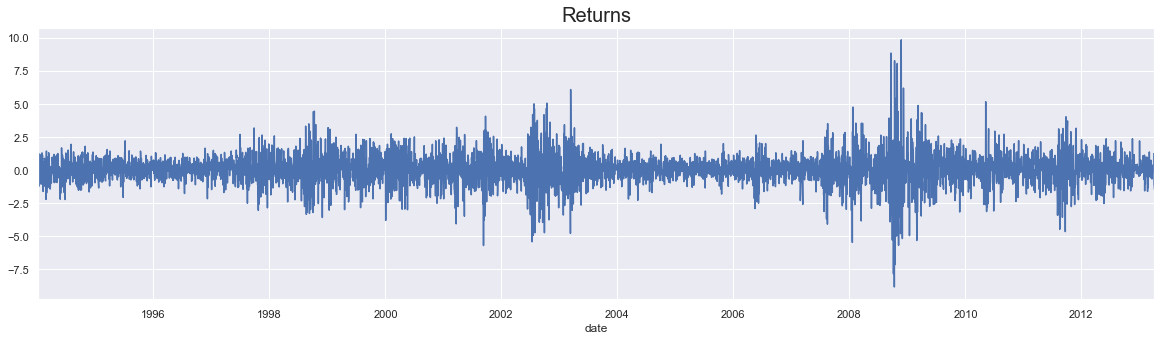

In [17]:
df['returns'].plot(figsize=(20,5))
plt.title('Returns',size=20)
plt.show()

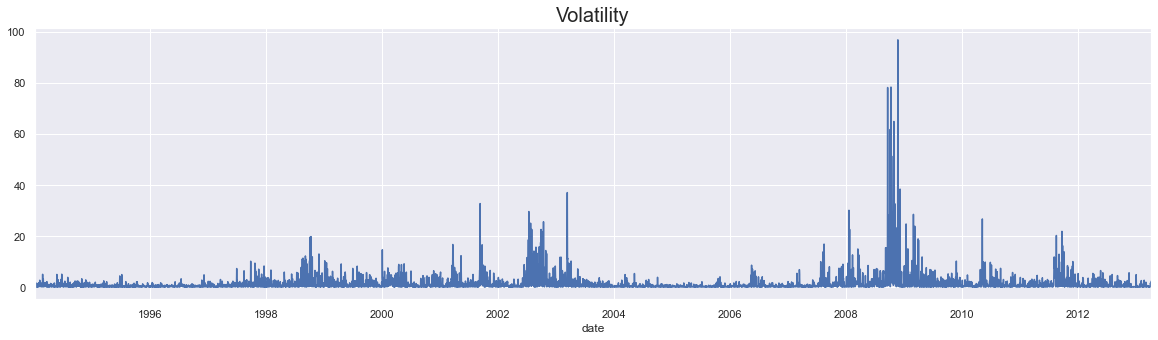

In [19]:
df['sq_returns'].plot(figsize=(20,5))
plt.title('Volatility',size=20)
plt.show()

In [21]:
## the periods of low positive and negative returns are expressed with low volatility
## those with sharp jumps or drops has high uncertainty

<function matplotlib.pyplot.show(*args, **kw)>

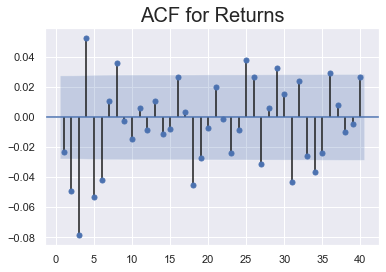

In [25]:
sgt.plot_acf(df.returns[1:],lags=40,zero=False)
plt.title('ACF for Returns',size=20)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

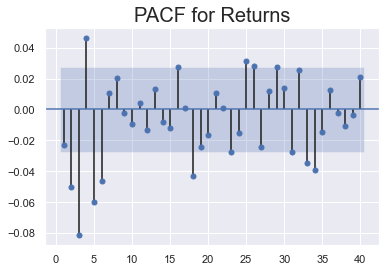

In [26]:
sgt.plot_pacf(df.returns[1:],lags=40,zero=False,method=('ols'))
plt.title('PACF for Returns',size=20)
plt.show

In [27]:
## Generally, if the time series resembles white_noise while it's squared version suggest using an AR(n) model
## we should opt to ARCH(n) to model variance otherwise we might have to experiment with different lag value until we
## find the model which captures the effect best

In [29]:
## first several lags are significant -- so cannot just use the rule of thumb 
## we should still look at the sqaured values to get an idea about which lags are significant
## that way even if we are not getting the suggested number of lags we are still gaining valuable insights on how
## the data performs

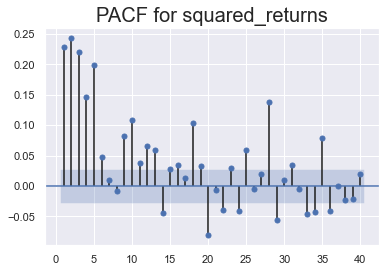

In [32]:
sgt.plot_pacf(df.sq_returns[1:],lags=40,zero=False)
plt.title('PACF for squared_returns',size=20)
plt.show()

In [33]:
## we can see that the first 6 lags are significant with first 5 yielding coeff between 0.15 to 0.25
## such high significant value to partial autocorelation among the first few lags shows there tend to be short-term
## trends in variance 

In [34]:
## another way to think about this is clustering: 
## where we have periods of high variation followed by period of high vriation
## as well as periods of low variation followed by periods of low variation 

## this is exactly what volatility characteristic stated elrlier so our dataset makes perfect sense

### the arch_model() method

In [36]:
from arch import arch_model

In [47]:
model_arch_1 = arch_model(df.returns[1:])
result_arch_1 = model_arch_1.fit(update_freq = 5)
result_arch_1.summary()

## if we do not pass argument to the fit method,, we will be using a type of model which is different from the ARCH
## we intended to use

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6972.734736835859
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6970.088042271316
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366189893
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Wed, Jan 20 2021   Df Residuals:                     5016
Time:                        12:08:36   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

In [39]:
## since this model has so many moving parts it takes several iterations before it converges,,
## this is due to fitting two equations at the same time

In [40]:
## it fits a model with certain coefficients then checks how well it has performed -- afterwards, it adjust the coefficients
## then again checks and adjusts(iterative )

In [41]:
## Generally the program decreases when the log-likelihood decreses 
## if negative, the absolute value should increse so that the program could stop
## if you want to see less about frequnct update about every single iterations ,, pass the parameter in the fit method

In [45]:
## Constant Mean of the model suggest that mean is time-invariant ,, so it includes neither past values nor past residuals
## therfore we should use either the default constant mean or mean=0 

### ARCH(1) model

In [49]:
model_arch_1 = arch_model(df.returns[1:],mean='Constant', vol='ARCH', p=1)
result_arch_1 = model_arch_1.fit(update_freq = 5)
result_arch_1.summary()


Iteration:      5,   Func. Count:     34,   Neg. LLF: 7660.088789377838
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7660.088782040875
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Wed, Jan 20 2021   Df Residuals:                     5017
Time:                        12:09:15   Df Model:                            3
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

In [50]:
## only took 6 iterations to complete .. the specification weere loose enough
## our model is light and doest not take too long to compute

In [52]:
## R-Squared === negative
## it is the mesure of explanatory variation away from the mean .. so if we are assuming a constant mean it makes
## little sense to expect this model to explain that deviation well 

## if the residual are simply the version of the original dataset, where every value is decreased by a constant ,, then
## there will be no actual variance -- hence the is nothing to explain

## this results in 0 r-sq value

In [53]:
## R-sq is a useful measure but not for ARCH model

In [55]:
## The log-likelihood is higher than the ARMIMA and ARMA model-- since LL measure the goodnesss of fit --
## this implies even a simpliest ARCH model yields a better estimate than the complex multi-lag ARIMA model

## the high complexity (2 eqn) is paying off

In [56]:
## the degree of freddom = 3 

## mean: p-value:: if a p-value has a number < -2 after the e-term ,, it is sig diff from 0 -- thus the mean coeff is 
## significant ,, therefore the coeff value is the baseline we use to deterimine the residual for the varince eqn 

In [57]:
## for vaolatility model,,
## both omega and alpha is significant 

## here we are estimating 3 coeff out of which all turned out to be significant 
## also, the LL is higher than any of the ARIMAX family we used 
## thus ARCH(1) becomes th best estimator of the data we have seen so far 


In [58]:
## ARCH can be use to predict only the future variance rather than future returns -- thus we can use it to see if
## can expect stability in the market but not predict if the prices would go up or down 

In [59]:
## we saw how simple ARCH model measures the volatility of returns

##### the effect of incresing the order of conditional variance 

### The Higher lag-ARCH model

#### ARCH(2) MODEL

In [60]:
model_arch_2 = arch_model(df.returns[1:],mean='Constant', vol='ARCH', p=2)
result_arch_2 = model_arch_2.fit(update_freq = 5)
result_arch_2.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: 7449.870533644225
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7449.545164098316
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -7449.55
Distribution:                  Normal   AIC:                           14907.1
Method:            Maximum Likelihood   BIC:                           14933.2
                                        No. Observations:                 5020
Date:                Wed, Jan 20 2021   Df Residuals:                     5016
Time:                        12:32:20   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0484  1.401e-02      3.455  5.495e-04 [2.095e-02,7.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6978  3.564e-02     19.580  2.272e-85 [  0.628,  0.768]
alpha[1]       0.2202  3.474e-02      6.339  2.311e-10 [  0.152,  0.288]
alpha[2]       0.2783  3.645e-02      7.635  2.260e-14 [  0.207,  0.350]
========================================================================

Covariance estimator: robust
"""

In [61]:
## number of iterations increases from 6 ---- > 9 since we are estimating additional coefficients --the one for
## sq-residual 2 periods ago 

In [62]:
## THE LL has increased while the IC has decreased -- thus ARCH(2) out perfroms the ARCH(1)

## all p-values for the coeff are significant -- thus favors ARCH(2) 
## increading the order resulted in a better model

In [63]:
model_arch_3 = arch_model(df.returns[1:],mean='Constant', vol='ARCH', p=3)
result_arch_3 = model_arch_3.fit(update_freq = 5)
result_arch_3.summary()

Iteration:      5,   Func. Count:     45,   Neg. LLF: 7278.805807411393
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7277.050453152619
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7277.050452148393
            Iterations: 11
            Function evaluations: 91
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -7277.05
Distribution:                  Normal   AIC:                           14564.1
Method:            Maximum Likelihood   BIC:                           14596.7
                                        No. Observations:                 5020
Date:                Wed, Jan 20 2021   Df Residuals:                     5015
Time:                        12:35:32   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0529  1.316e-02      4.018  5.875e-05 [2.707e-02,7.865e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5012  2.834e-02     17.685  5.505e-70 [  0.446,  0.557]
alpha[1]       0.1570  2.649e-02      5.926  3.108e-09 [  0.105,  0.209]
alpha[2]       0.2197  2.588e-02      8.489  2.077e-17 [  0.169,  0.270]
alpha[3]       0.2804  3.354e-02      8.359  6.302e-17 [  0.215,  0.346]
========================================================================

Covariance estimator: robust
"""

In [64]:
## THE ll KEEPS on increasing -- but by smaller amount ,, the AIC also decrese while all coeff are significant 

## trian and error -- keep on incresing until 13 lag where one fo the coeff is insignificant 

In [65]:
## increasing more and more values reduces the additonal effect the each one has on log-likelihood


## the more past -squared residuals we take into account, the less imp each additional one becomes  (diminishing-marginal
#log likelihood )

### GARCH(1,1)

In [68]:
## fit GARCH(1,1) model with serially uncorrelated data -- i.e the mean value does not rely on past values or errors
## just a constant mean model

In [70]:
model_garch_1_1 = arch_model(df.returns[1:], mean='Constant', vol='GARCH', p=1,q=1)
result_garch_1_1 = model_garch_1_1.fit(update_freq=5)
result_garch_1_1.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6972.734736835859
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6970.088042271316
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366189893
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Wed, Jan 20 2021   Df Residuals:                     5016
Time:                        13:14:27   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

In [71]:
## Log Likelihood is even grater than we have for arch(12) -- this suggest adding a single past variance gives more
## predictive power than 11 squared residuals

## we observed the same pattern going from MA to ARMA
## THUS including past values as a form of baseline. provides much greater accuracy  -- explain higher likelihood of
## of our prediction

## since all coeff are sig and we get a high log likelihood -- this model becomes the front-runner for measuring volatili
# volatility 

### Higher -lag GARCH models

In [ ]:
## no higher order GARCH models out-perfroms the GARCH(1,1) when it comes to variance of market returns 
## this is beacuse the recursive nature of past conditional variances are computed

## all the effects of conditional varince of 2 days ago will be contained in a conditional variance of yesterday
## thus no need to include more than 1 GARCH compoenet 

In [ ]:
## in arch_model( ) p -> ARCH order while q-> GARCH order 

In [72]:
model_garch_1_2 = arch_model(df.returns[1:], mean='Constant', vol='GARCH', p=1,q=2)
result_garch_1_2 = model_garch_1_2.fit(update_freq=5)
result_garch_1_2.summary()

Iteration:      5,   Func. Count:     44,   Neg. LLF: 6978.593507189082
Iteration:     10,   Func. Count:     80,   Neg. LLF: 6970.063523580382
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.0583663691805
            Iterations: 12
            Function evaluations: 95
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13950.1
Method:            Maximum Likelihood   BIC:                           13982.7
                                        No. Observations:                 5020
Date:                Wed, Jan 20 2021   Df Residuals:                     5015
Time:                        13:26:01   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.184e-02      3.938  8.219e-05 [2.341e-02,6.982e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  2.908e-03      3.761  1.696e-04 [5.236e-03,1.663e-02]
alpha[1]       0.0835  1.189e-02      7.020  2.225e-12   [6.017e-02,  0.107]
beta[1]        0.9089      0.188      4.845  1.265e-06     [  0.541,  1.277]
beta[2]    1.3381e-08      0.180  7.443e-08      1.000     [ -0.352,  0.352]
============================================================================

Covariance estimator: robust
"""

In [73]:
## beta-2 has p-value of 1 -- thus this is the case of full multicollinearity (perfect muticollinearity)
## all explanatory power of the conditional variance 2 periods ago is captired is captured from the variance of last period


In [74]:
model_garch_1_3 = arch_model(df.returns[1:], mean='Constant', vol='GARCH', p=1,q=3)
result_garch_1_3 = model_garch_1_3.fit(update_freq=5)
result_garch_1_3.summary()

Iteration:      5,   Func. Count:     51,   Neg. LLF: 6993.438671672955
Iteration:     10,   Func. Count:     97,   Neg. LLF: 6972.430988010177
Iteration:     15,   Func. Count:    138,   Neg. LLF: 6970.058669787428
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366229721
            Iterations: 17
            Function evaluations: 154
            Gradient evaluations: 17


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13952.1
Method:            Maximum Likelihood   BIC:                           13991.2
                                        No. Observations:                 5020
Date:                Wed, Jan 20 2021   Df Residuals:                     5014
Time:                        13:28:24   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.179e-02      3.954  7.683e-05 [2.351e-02,6.972e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0109  8.178e-03      1.337      0.181 [-5.092e-03,2.696e-02]
alpha[1]       0.0835  6.076e-02      1.374      0.169   [-3.561e-02,  0.203]
beta[1]        0.9089      2.154      0.422      0.673      [ -3.313,  5.131]
beta[2]    1.6627e-12      3.384  4.913e-13      1.000      [ -6.633,  6.633]
beta[3]        0.0000      1.298      0.000      1.000      [ -2.543,  2.543]
=============================================================================

Covariance estimator: robust
"""

In [75]:
## the same insignificant p-value

### GARCH(2,1)

In [77]:
model_garch_2_1 = arch_model(df.returns[1:], mean='Constant', vol='GARCH', p=2,q=1)
result_garch_2_1 = model_garch_2_1.fit(update_freq=5)
result_garch_2_1.summary()

Iteration:      5,   Func. Count:     44,   Neg. LLF: 6973.212488591025
Iteration:     10,   Func. Count:     85,   Neg. LLF: 6967.735893399618
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6967.73102007606
            Iterations: 12
            Function evaluations: 99
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6967.73
Distribution:                  Normal   AIC:                           13945.5
Method:            Maximum Likelihood   BIC:                           13978.1
                                        No. Observations:                 5020
Date:                Wed, Jan 20 2021   Df Residuals:                     5015
Time:                        13:29:50   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.187e-02      3.922  8.779e-05 [2.329e-02,6.982e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0129  4.097e-03      3.158  1.589e-03  [4.908e-03,2.097e-02]
alpha[1]       0.0547  1.665e-02      3.286  1.017e-03  [2.208e-02,8.735e-02]
alpha[2]       0.0389  2.345e-02      1.659  9.709e-02 [-7.055e-03,8.488e-02]
beta[1]        0.8974  1.712e-02     52.415      0.000      [  0.864,  0.931]
=============================================================================

Covariance estimator: robust
"""

In [78]:
## 9.709e-02 >0.05, thus not sig different than zero,, better to avoid this model

In [79]:
model_garch_3_1 = arch_model(df.returns[1:], mean='Constant', vol='GARCH', p=3,q=1)
result_garch_3_1 = model_garch_3_1.fit(update_freq=5)
result_garch_3_1.summary()

Iteration:      5,   Func. Count:     49,   Neg. LLF: 6974.886816187958
Iteration:     10,   Func. Count:     94,   Neg. LLF: 6968.53820803195
Iteration:     15,   Func. Count:    134,   Neg. LLF: 6967.731020048997
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6967.731020049635
            Iterations: 15
            Function evaluations: 134
            Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6967.73
Distribution:                  Normal   AIC:                           13947.5
Method:            Maximum Likelihood   BIC:                           13986.6
                                        No. Observations:                 5020
Date:                Wed, Jan 20 2021   Df Residuals:                     5014
Time:                        13:30:55   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.187e-02      3.924  8.721e-05 [2.330e-02,6.982e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0129  4.816e-03      2.687  7.217e-03  [3.500e-03,2.238e-02]
alpha[1]       0.0547  1.665e-02      3.285  1.019e-03  [2.207e-02,8.736e-02]
alpha[2]       0.0389  2.505e-02      1.553      0.120 [-1.018e-02,8.800e-02]
alpha[3]       0.0000  2.572e-02      0.000      1.000 [-5.041e-02,5.041e-02]
beta[1]        0.8974  2.245e-02     39.978      0.000      [  0.853,  0.941]
=============================================================================

Covariance estimator: robust
"""

In [80]:
## both alpha_1 and alpda_2 are not significant. -- this model fails as well 

In [81]:
## THus GARCH(1,1) is the best model for measuring volatility of returns

In [82]:
## thus no need to rely on overly complicated model